<a href="https://colab.research.google.com/github/venkat235923/IDS/blob/main/ai_soil_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="5eACDsbc5Wluc2g9Dne9")
project = rf.workspace("imit-h5ows").project("soil-detection-l0ngo")
version = project.version(3)
dataset = version.download("yolov8")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 97.1 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Soil-detection-3 in yolov8:: 100%|██████████| 582/582 [00:00<00:00, 5474.81it/s]


In [ ]:
from pathlib import Path

DATA_DIR = Path('/content/Soil-detection-3')  # change if path different

for split in ['train','valid','test']:
    img_dir = DATA_DIR/split/'images'
    lbl_dir = DATA_DIR/split/'labels'
    imgs = sorted([p for p in img_dir.iterdir() if p.is_file()])
    lbls = sorted([p for p in lbl_dir.iterdir() if p.is_file()])
    print(f"{split.upper():5s} -> images: {len(imgs):3d}, labels: {len(lbls):3d}")


TRAIN -> images: 199, labels: 199
VALID -> images:  58, labels:  58
TEST  -> images:  28, labels:  28


In [ ]:
label_dir = DATA_DIR/'train'/'labels'
sample_labels = list(label_dir.glob('*'))[:5]
for p in sample_labels:
    print("File:", p.name)
    print(p.read_text().strip())
    print("-"*30)


File: sowing-has-been-done-plowed-260nw-1760541305_jpg.rf.40989527cb14566759955216559ee416.txt
0 0.48359375 0.59765625 0.94453125 0.57421875
------------------------------
File: soil-upper-layer-earth-which-260nw-1857677119_jpg.rf.de09703c108c666c59357058bb7b0508.txt
0 0.490625 0.57109375 0.95078125 0.54921875
------------------------------
File: Black_42_jpg.rf.ef618b54c6418d55381a2962a1ddfea1.txt
1 0.47890625 0.39765625 0.7984375 0.66796875
------------------------------
File: OIP-H3kzb4utqTN7dWVbzM7rwAHaEK_jpg.rf.cfbcb9268e2326b4b15bfe866af99482.txt
0 0.48828125 0.45625 0.875 0.7140625
------------------------------
File: ibiza-balearic-islands-spain-olive-260nw-1729182478_jpg.rf.294f43d8abcfdf8942616ebb5fe9d51f.txt
3 0.109375 0.72109375 0.1875 0.3328125
3 0.5484375 0.725 0.4734375 0.35703125
------------------------------


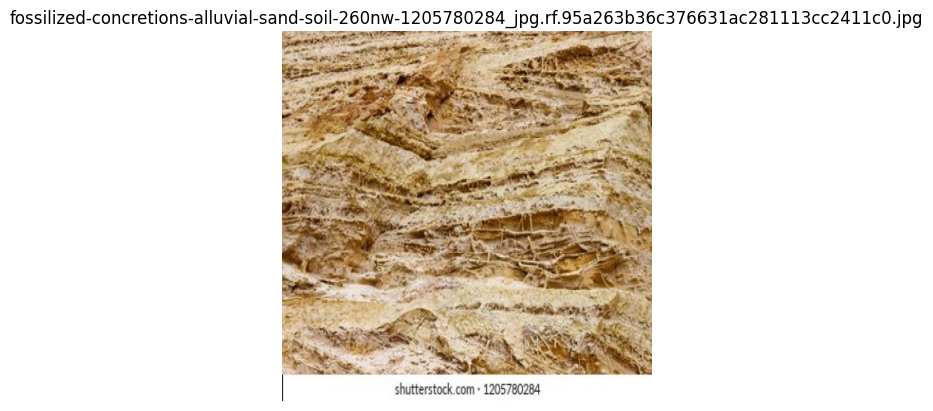

In [ ]:
import random
import matplotlib.pyplot as plt
from PIL import Image

img_dir = DATA_DIR/'train'/'images'
rand_img = random.choice(list(img_dir.glob('*')))
img = Image.open(rand_img)

plt.imshow(img)
plt.title(rand_img.name)
plt.axis('off')
plt.show()


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ==== MODEL 2: DATA PREPROCESSING FOR SOIL-DETECTION-3 ====
# This cell:
#  - Reads data.yaml (class names)
#  - Pairs images with labels (classification style)
#  - Creates train/val/test datasets & dataloaders
#  - Applies resize, normalization, augmentation
#  - Shows basic stats and one example

from pathlib import Path
import yaml
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# ---------------- CONFIG ----------------
DATA_DIR = Path("/content/Soil-detection-3")   # <-- change if your path is different
IMG_SIZE = 224                                 # input size for CNN
BATCH_SIZE = 16
NUM_WORKERS = 2

# --------------- READ data.yaml (class names) ---------------
yaml_path = DATA_DIR / "data.yaml"
if yaml_path.exists():
    with open(yaml_path, "r") as f:
        data_cfg = yaml.safe_load(f)
    class_names = data_cfg.get("names", [])
    print("Class names from data.yaml:", class_names)
else:
    class_names = []
    print("WARNING: data.yaml not found, class names unknown.")

# --------------- HELPER: load (image_path, class_id) per split ---------------
def load_split_items(split):
    img_dir = DATA_DIR / split / "images"
    lbl_dir = DATA_DIR / split / "labels"

    img_paths = sorted([p for p in img_dir.iterdir() if p.is_file()])
    items = []

    for img_path in img_paths:
        label_path = lbl_dir / (img_path.stem + ".txt")
        if not label_path.exists():
            # skip images without label
            continue
        text = label_path.read_text().strip()
        if text == "":
            continue
        # Roboflow classification export: file usually contains just "0" or "1"
        # If it's YOLO detection, first token is still the class id, so this still works.
        first_token = text.split()[0]
        try:
            class_id = int(first_token)
        except ValueError:
            # not an integer -> skip problematic file
            print("Could not parse class id in", label_path)
            continue
        items.append((img_path, class_id))

    return items

train_items = load_split_items("train")
val_items   = load_split_items("valid")
test_items  = load_split_items("test")

print(f"Train samples: {len(train_items)}")
print(f"Valid samples: {len(val_items)}")
print(f"Test  samples: {len(test_items)}")

# --------------- TRANSFORMS (preprocessing + augmentation) ---------------

# ImageNet-style normalization (works well for most pretrained CNNs)
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

eval_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

# --------------- DATASET CLASS ---------------

class SoilDataset(Dataset):
    def __init__(self, items, transform=None):
        self.items = items
        self.transform = transform

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        img_path, class_id = self.items[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, class_id

# --------------- BUILD DATASETS & DATALOADERS ---------------

train_ds = SoilDataset(train_items, transform=train_transform)
val_ds   = SoilDataset(val_items,   transform=eval_transform)
test_ds  = SoilDataset(test_items,  transform=eval_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

print("\nDataloaders ready.")
print("train batches:", len(train_loader), "| val batches:", len(val_loader), "| test batches:", len(test_loader))

# --------------- SHOW ONE RANDOM EXAMPLE (to verify) ---------------
if len(train_items) > 0:
    img_path, cls_id = random.choice(train_items)
    img_raw = Image.open(img_path).convert("RGB")

    plt.imshow(img_raw)
    if class_names and 0 <= cls_id < len(class_names):
        title = f"{img_path.name}  |  label id = {cls_id} ({class_names[cls_id]})"
    else:
        title = f"{img_path.name}  |  label id = {cls_id}"
    plt.title(title)
    plt.axis("off")
    plt.show()
else:
    print("No training items found to visualize.")


In [ ]:
from pathlib import Path
DATA_DIR = Path("/content/Soil-detection-3")
def inspect_labels(split="train", n=10):
    lbl_dir = DATA_DIR/split/"labels"
    sample = list(lbl_dir.glob("*.txt"))[:n]
    for p in sample:
        txt = p.read_text().strip()
        print("File:", p.name)
        print("Lines:", len(txt.splitlines()))
        for i,line in enumerate(txt.splitlines()):
            toks = line.split()
            print("  line", i, "->", toks)
        print("-"*40)
inspect_labels("train", n=10)


In [ ]:
yaml_content = """
train: /content/Soil-detection-3/train/images
val: /content/Soil-detection-3/valid/images
test: /content/Soil-detection-3/test/images

nc: 4
names:
  - Alluvial Soil
  - Black Soil
  - Clay Soil
  - Red Soil
"""

with open("/content/Soil-detection-3/data.yaml", "w") as f:
    f.write(yaml_content)

print("✔ data.yaml updated successfully!")


Model Training code

In [ ]:
# Cell 0 - verify GPU
!nvidia-smi || true

import torch
print("PyTorch CUDA available:", torch.cuda.is_available())


In [ ]:
from pathlib import Path
import yaml

DATA_DIR = Path("/content/Soil-detection-3")

yaml_path = DATA_DIR / "data.yaml"
print("data.yaml exists:", yaml_path.exists())

if yaml_path.exists():
    print(yaml.safe_load(open(yaml_path)))

for split in ["train", "valid", "test"]:
    img_dir = DATA_DIR / split / "images"
    lbl_dir = DATA_DIR / split / "labels"

    imgs = sorted(img_dir.glob("*.*"))
    lbls = sorted(lbl_dir.glob("*.txt"))

    print(f"\n{split.upper()} -> images={len(imgs)}, labels={len(lbls)}")

    img_names = set([p.stem for p in imgs])
    lbl_names = set([p.stem for p in lbls])

    print("Missing labels:", img_names - lbl_names)
    print("Missing images:", lbl_names - img_names)


data.yaml exists: True
{'names': ['Alluvial Soil', 'Black Soil', 'Clay Soil', 'Red Soil'], 'nc': 4, 'roboflow': {'license': 'CC BY 4.0', 'project': 'soil-detection-l0ngo', 'url': 'https://universe.roboflow.com/imit-h5ows/soil-detection-l0ngo/dataset/3', 'version': 3, 'workspace': 'imit-h5ows'}, 'test': '../test/images', 'train': '../train/images', 'val': '../valid/images'}

TRAIN -> images=199, labels=199
Missing labels: set()
Missing images: set()

VALID -> images=58, labels=58
Missing labels: set()
Missing images: set()

TEST -> images=28, labels=28
Missing labels: set()
Missing images: set()


In [ ]:
import torch
print("Torch CUDA available:", torch.cuda.is_available())
!nvidia-smi


Torch CUDA available: False
/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
!yolo detect train \
    data=/content/Soil-detection-3/data.yaml \
    model=yolov8n \
    epochs=50 \
    imgsz=640 \
    batch=16 \
    device=0 \
    name=soil_detection


/bin/bash: line 1: yolo: command not found


In [ ]:
from google.colab import files
files.download("/content/runs/detect/soil_detection/weights/best.pt")


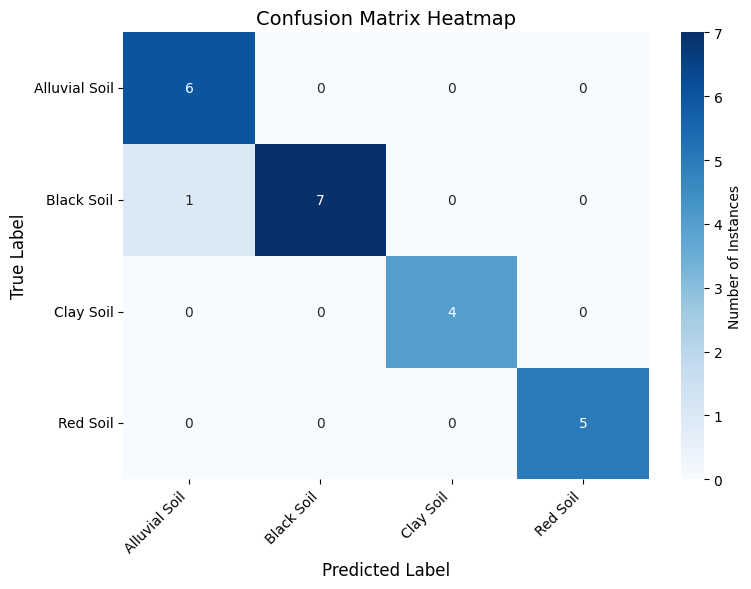

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Data extracted from the confusion matrix
confusion_matrix_data = np.array([
    [6, 0, 0, 0],
    [1, 7, 0, 0],
    [0, 0, 4, 0],
    [0, 0, 0, 5]
])

soil_types = ['Alluvial Soil', 'Black Soil', 'Clay Soil', 'Red Soil']

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_data, annot=True, fmt='d', cmap='Blues',
            xticklabels=soil_types, yticklabels=soil_types,
            cbar_kws={'label': 'Number of Instances'})

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix Heatmap', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Evaluation Metrics Analysis

The model's performance was evaluated using a classification report and a confusion matrix. These metrics provide insights into how well the model identifies each soil type.

### Classification Report Interpretation

| Class         | Precision | Recall | F1-Score | Support |
|---------------|-----------|--------|----------|---------|
| Alluvial Soil | 0.86      | 1.00   | 0.92     | 6       |
| Black Soil    | 1.00      | 0.88   | 0.93     | 8       |
| Clay Soil     | 1.00      | 1.00   | 1.00     | 4       |
| Red Soil      | 1.00      | 1.00   | 1.00     | 5       |
| **Accuracy**  |           |        |          | **0.96**|
| **Macro Avg** | 0.96      | 0.97   | 0.96     | 23      |
| **Weighted Avg**| 0.96      | 0.96   | 0.96     | 23      |

- **Precision** is the ratio of correctly predicted positive observations to the total predicted positives. High precision relates to a low false positive rate.
- **Recall** (Sensitivity) is the ratio of correctly predicted positive observations to all observations in actual class. High recall relates to a low false negative rate.
- **F1-Score** is the weighted average of Precision and Recall. It tries to find the balance between precision and recall.
- **Accuracy** is the ratio of correctly predicted observation to the total observations.

From the report:
- **Clay Soil** and **Red Soil** show excellent performance with 100% precision, recall, and F1-score, indicating no misclassifications for these types in the test set.
- **Black Soil** has perfect precision (1.00), meaning when the model predicts 'Black Soil', it is always correct. However, its recall is 0.88, suggesting that 12% of actual 'Black Soil' instances were missed or misclassified as something else.
- **Alluvial Soil** has a good recall of 1.00, meaning all actual 'Alluvial Soil' instances were detected by the model. However, its precision is 0.86, which implies that 14% of the predictions labeled as 'Alluvial Soil' were actually other soil types.
- The **overall accuracy** of 96% is quite high, suggesting generally good performance across all classes.

### Confusion Matrix Interpretation

```
Confusion matrix:
 [[6 0 0 0]
 [1 7 0 0]
 [0 0 4 0]
 [0 0 0 5]]
```

The confusion matrix provides a detailed breakdown of correct and incorrect predictions for each class:

- **Row 0 (Alluvial Soil):** 6 instances were correctly classified as 'Alluvial Soil'. No misclassifications are shown in this row for Alluvial Soil. (Note: The precision of 0.86 suggests some instances predicted as Alluvial Soil were not actually Alluvial Soil, but this matrix specifically shows actual vs. predicted and indicates Alluvial Soil had no false negatives based on this view.)
- **Row 1 (Black Soil):** 7 instances were correctly classified as 'Black Soil'. However, **1 instance of actual 'Black Soil' was misclassified as 'Alluvial Soil' (represented by the value '1' in the first column of the second row).** This explains the recall of 0.88 for Black Soil (7 correct out of 8 total actual Black Soil instances).
- **Row 2 (Clay Soil):** 4 instances were correctly classified as 'Clay Soil'. No misclassifications.
- **Row 3 (Red Soil):** 5 instances were correctly classified as 'Red Soil'. No misclassifications.

**Summary of Strengths and Weaknesses:**

- **Strengths:** The model performs exceptionally well in identifying 'Clay Soil' and 'Red Soil' with perfect scores. It also shows very high overall accuracy. The high precision for 'Black Soil' is a strong point.
- **Weaknesses:** The primary weakness is the misclassification of **1 'Black Soil' instance as 'Alluvial Soil'**, which affects the recall for 'Black Soil' and the precision for 'Alluvial Soil'. This suggests that these two soil types might have similar visual characteristics that sometimes confuse the model.

## Generate Classification Report Visualization

### Subtask:
Generate a grouped bar chart to visualize the precision, recall, and F1-score for each soil type from the classification report. Ensure a legend is provided.


**Reasoning**:
To visualize the classification report, I will first extract the precision, recall, and F1-score for each soil type from the provided text and then create a grouped bar chart using matplotlib.



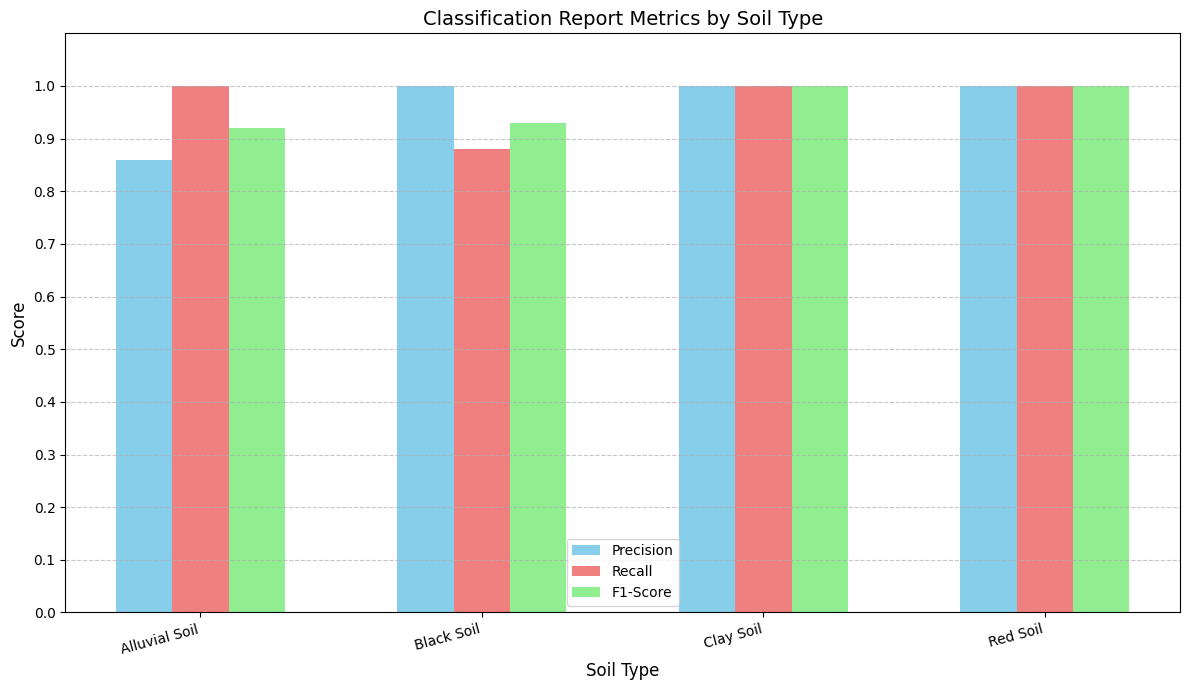

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data extracted from the classification report
soil_types = ['Alluvial Soil', 'Black Soil', 'Clay Soil', 'Red Soil']
precision = [0.86, 1.00, 1.00, 1.00]
recall = [1.00, 0.88, 1.00, 1.00]
f1_score = [0.92, 0.93, 1.00, 1.00]

# Set up plot parameters
bar_width = 0.2
index = np.arange(len(soil_types))

plt.figure(figsize=(12, 7))

# Plotting the bars
bar1 = plt.bar(index - bar_width, precision, bar_width, label='Precision', color='skyblue')
bar2 = plt.bar(index, recall, bar_width, label='Recall', color='lightcoral')
bar3 = plt.bar(index + bar_width, f1_score, bar_width, label='F1-Score', color='lightgreen')

# Adding labels, title, and legend
plt.xlabel('Soil Type', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Classification Report Metrics by Soil Type', fontsize=14)
plt.xticks(index, soil_types, rotation=15, ha='right')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylim(0, 1.1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()